https://www.gdeltproject.org/data/lookups/FIPS.country.txt

In [6]:
country_code = 'YM'

In [299]:
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


from scipy import stats

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')


In [300]:
class HumanitarianCrisisModel:
    
    def __init__(self, country_code, frequency='d', event_count=10000):
        self.country_code = country_code
        self.frequency = frequency
        self.event_count = event_count
        self.query_job = self.run_query()
        self.country_df = self.convert_query_to_df()
        self.labeled_df = self.label_df()
        self.clean_df = self.clean_df()
        self.humanitarian_crisis_ts = self.group_df()
        self.country_name = self.get_country_name()
        self.residual = self.get_residual()
        self.best_order = self.run_auto_arima()
        
        
        
    def run_query(self):
                
        credentials = service_account.Credentials.from_service_account_file(
            '../keys/projecttest-318006-34f075e5bede.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
        )

        client = bigquery.Client(credentials=credentials, project=credentials.project_id)

        query = f"""
        SELECT SQLDATE, EventCode
        FROM `gdelt-bq.gdeltv2.events` 
        WHERE ActionGeo_CountryCode = @country
        ORDER BY SQLDATE DESC
        LIMIT @event_count
        """

        # parameterized query that extract event rows from the GDELT dataset in BigQuery
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("country", "STRING", self.country_code),
                bigquery.ScalarQueryParameter("event_count", "INT64", self.event_count),

            ]
        )
        query_job = client.query(query, job_config=job_config) 
        
        return query_job
    
    def convert_query_to_df(self):
        
        # converts the query into a dataframe
        country_df = self.query_job.to_dataframe()
        
        return country_df
    
    def label_df(self):
        # determines which events should be labeled as humanitarian crisis events
        humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                                  '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                                  '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                                  '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                                  '1833', '184']

        self.country_df['IsHumanitarianCrisis'] = self.country_df.EventCode.isin(humanitarian_crisis_events)
        labeled_df  = self.country_df
        return labeled_df
    
    
    
    def clean_df(self):

        # Structure the dataframe; set the event date as the index
        self.labeled_df.SQLDATE = pd.to_datetime(self.labeled_df.SQLDATE, format='%Y%m%d', errors='ignore')
        self.labeled_df = self.labeled_df.set_index('SQLDATE')
        clean_df = self.labeled_df
        
        return clean_df
    
    def group_df(self):

        # Group the events by the given frequency
        country_df_grouped = self.clean_df['IsHumanitarianCrisis'].groupby(pd.Grouper(freq=self.frequency)).agg(['sum','count','mean'])
        country_df_grouped.columns = ['HumanitarianCrisisEvents', 'TotalEvents', 'HumanitarianCrisisProportions']
        humanitarian_crisis_ts = country_df_grouped.HumanitarianCrisisProportions
        
        return humanitarian_crisis_ts
    
    def get_country_name(self):

        # Lookup the name of the given country code
        lookup_df = pd.read_csv('../data/country_code_lookup.csv')
        country_name = lookup_df[lookup_df['Country Code'] == self.country_code].Country.values[0]
        
        return country_name

    def plot_original_data(self):
        # plot the original data
        plt.figure(figsize=(14, 4))
        plt.figtext(.5,.9,f'Proportion of News Signaling Humanitarian Crisis in {self.country_name}\n', fontsize=20, ha='center')
        plt.plot(self.humanitarian_crisis_ts, color='#D2042D') ;
        
        
    def stationarity_test(self, ts, window=30, title='Stationarity Test'):
        # performn a Dickey-Full Test on the Time Series 
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(ts, autolag = 'AIC')

        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
        for k, v in dftest[4].items():
            dfoutput[f'Critiical Values: {k}'] = v

        print(dfoutput)

        rollmean = ts.rolling(window=window).mean()
        rollstd = ts.rolling(window=window).std()
        
        # plot the Time Series data against the rolling mean and the std to visualize stationarity
        plt.figure(figsize=(14, 4))
        original = plt.plot(ts, color = '#D2042D', label = 'Original')
        mean = plt.plot(rollmean, color = '#0092F4', label = 'Rolling Mean')
        std = plt.plot(rollstd, color = '#99d3fb', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.figtext(.5,.9,f'{title}\n', fontsize=20, ha='center')
        
        
    def decompose_ts(self):
        
        decomposition = seasonal_decompose(self.humanitarian_crisis_ts)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        
        # plot the trend and seasonality of data using seasonal decompose method from statsmodels
        plt.figure(figsize=(14,12))
        plt.subplot(411)
        plt.plot(self.humanitarian_crisis_ts, label = 'Original', color = '#D2042D')
        plt.legend()
        plt.subplot(412)
        plt.plot(trend, label = 'Trend', color = '#99d3fb')
        plt.legend()
        plt.subplot(413)
        plt.plot(seasonal, label = 'Seasonal', color = '#0092F4')
        plt.legend()
        plt.subplot(414)
        plt.plot(self.residual, label = 'Residual', color = '#003a62')
        plt.legend(loc='upper right')
        
    def get_residual(self):
        decomposition = seasonal_decompose(self.humanitarian_crisis_ts)
        residual = decomposition.resid
        residual.dropna(inplace=True)
        
        return residual
        
    def plot_residual(self):
        
        (mu, sigma) = stats.norm.fit(self.residual)
        
        plt.figure(figsize=(10,6))
        plt.hist(self.residual, color='#D2042D')
        plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
        plt.ylabel('Frequency')
        plt.figtext(.5,.9,f'Residual distribution\n', fontsize=20, ha='center')
        
    def run_auto_arima(self):
        
        stepwise_fit = auto_arima(self.humanitarian_crisis_ts, trace=True, suppress_warnings=True)
        stepwise_fit.summary()
        
        return stepwise_fit.order
        
    def run_best_ARIMA_model(self):
        
        model = ARIMA(humanitarian_crisis_ts, order=self.best_order)
        model = model.fit()
        model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-188.802, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-178.032, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-180.421, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-179.992, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-192.516, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-183.373, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-189.400, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-186.107, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-188.556, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-187.706, Time=0.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.074 seconds
Results of Dickey-Fuller Test:
Test S

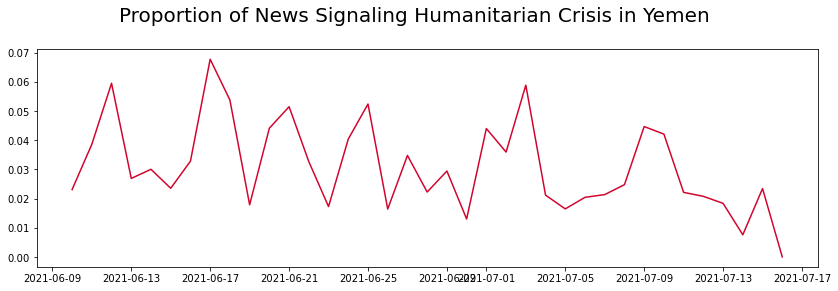

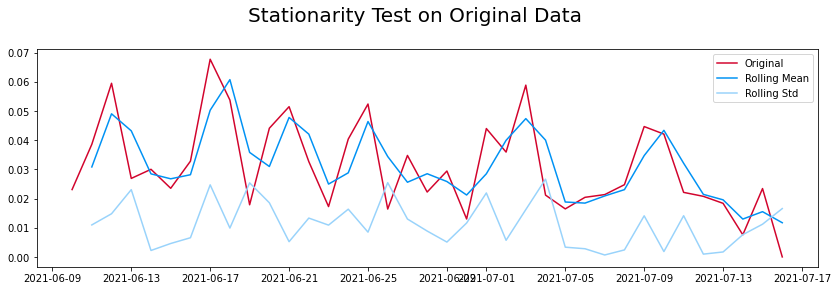

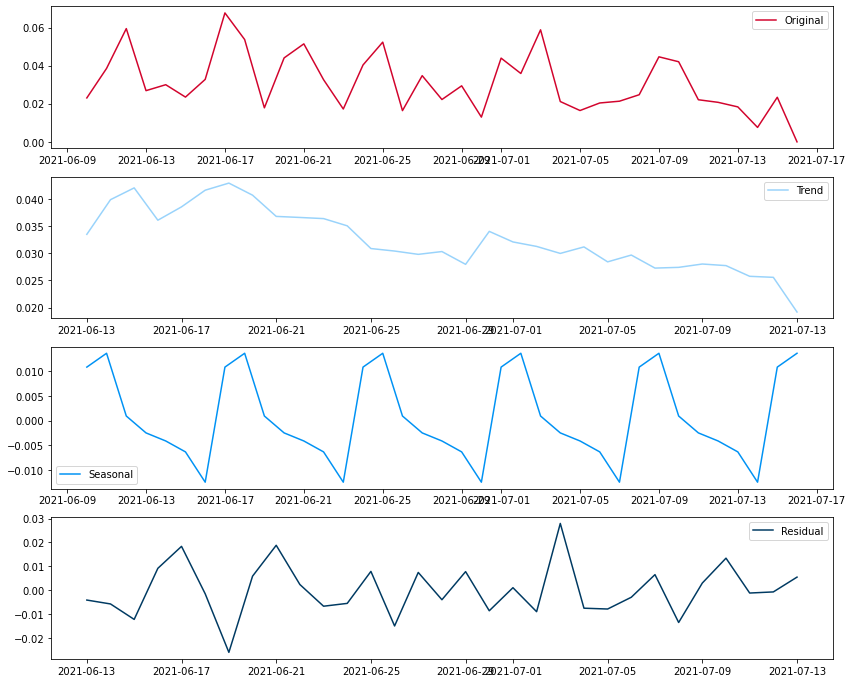

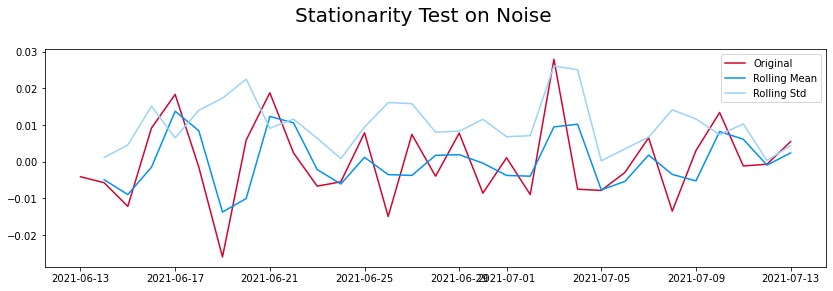

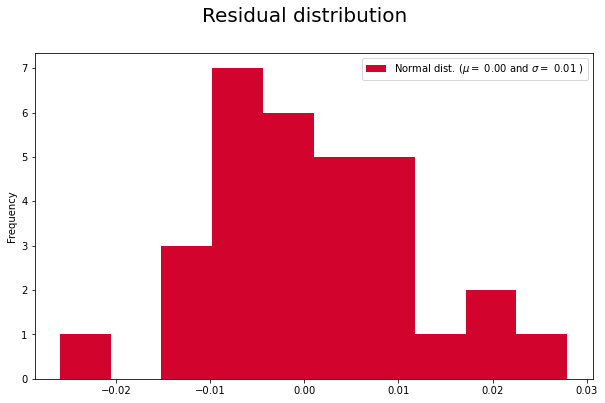

In [301]:
new_model  = HumanitarianCrisisModel('YM')
new_model.plot_original_data()
ts = new_model.humanitarian_crisis_ts
new_model.stationarity_test(ts=ts, window=2, title='Stationarity Test on Original Data')
new_model.decompose_ts()
resid = new_model.residual
new_model.stationarity_test(ts=resid, window=2, title='Stationarity Test on Noise')
new_model.plot_residual()

In [302]:
new_model.run_auto_arima()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-188.802, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-178.032, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-180.421, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-179.992, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-192.516, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-183.373, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-189.400, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-186.107, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-188.556, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-187.706, Time=0.08 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.094 seconds


(2, 1, 1)

In [303]:
new_model.run_best_ARIMA_model()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-887.201, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-886.188, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-891.651, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-890.399, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-500.644, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-890.148, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-889.631, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-888.582, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-827.286, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.668 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 448.825
Date:                Thu, 15 Jul 2021   AIC                           -891.651
Time:                        18:25:41   BIC                           -882.762
Sample:                             0   HQIC                          -888.039
                                - 143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0310      0.003      9.971      0.000       0.025       0.037
ar.L1          0.2299      0.073      3.150      0.002       0.087       0.373
sigma2         0.0001   1.04e-05     10.613      0.000    8.96e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                66.05
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.07
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    ARMA Model Results                                   
=========================================================================================
Dep. Variable:     HumanitarianCrisisProportions   No. Observations:                  143
Model:                                ARMA(1, 0)   Log Likelihood                 448.825
Method:                                  css-mle   S.D. of innovations              0.010
Date:                           Thu, 15 Jul 2021   AIC                           -891.651
Time:                                   18:25:45   BIC                           -882.762
Sample:                               10-24-2018   HQIC                          -888.039
                                    - 07-14-2021                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0403      0.001     35.478      0.000       0.038       0.043
ar.L1.HumanitarianCrisisProportions     0.2295      0.083      2.769      0.006       0.067       0.392
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.3579           +0.0000j            4.3579            0.0000
-----------------------------------------------------------------------------
"""

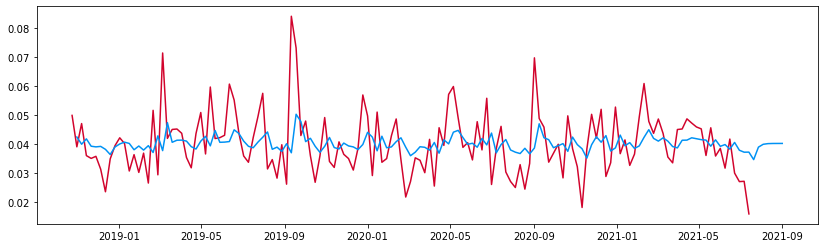

In [172]:
end=len(humanitarian_crisis_ts)
pred = model.predict(start=1, end=end+6)

plt.figure(figsize=(14,4))
plt.plot(humanitarian_crisis_ts, color='#D2042D')
plt.plot(pred, color='#0092F4')